<a href="https://colab.research.google.com/github/arva29/InformationRetrievalProject/blob/main/BoardGameComplexityAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **BOARDGAME COMPLEXITY ANALYSIS**



## **Importing dataset**

In [ ]:
from google.colab import files
import io
import pandas as pd

uploaded = files.upload()

Saving boardgames_dataset_NEW.csv to boardgames_dataset_NEW.csv


In [ ]:
df = pd.read_csv(io.BytesIO(uploaded['boardgames_dataset.csv']))
df.drop(df[df['weight'] == 0].index, inplace = True)
df.drop(df.columns[0],axis = 1,  inplace = True)
df

,id,name,year,publisher,weight,rules,raw_rules
0,367525,3000 SCOUNDRELS,2022,UNEXPECTED GAMES,2.1667,"setup before your first game, place all clear ...","SETUP\nBefore your first game, place all clear..."
1,154173,7 RONIN,2013,GREY FOX GAMES,2.2105,setup choose or determine randomly who is the ...,SETUP\nChoose or determine randomly who is the...
2,68448,7 WONDERS,2010,ASMODEE,2.3211,"setup depending on the number of players, retu...","Setup\nDepending on the number of players, ret..."
3,141517,A STUDY IN EMERALD,2013,TREEFROG GAMES,3.4538,setup shuffle the secret identity cards and de...,SETUP\nShuffle the Secret Identity cards and d...
4,253499,A WAR OF WHISPERS,2020,STARLING GAMES,2.5488,setup each player chooses a matching player bo...,SETUP\nEach player chooses a matching player b...
...,...,...,...,...,...,...,...
304,146451,WRATH OF KINGS,2014,COOL MINI OR NOT,2.9000,basics distances (in inches) may be measured a...,BASICS\nDistances (in inches) may be measured ...
305,8593,WRECKAGE,2003,FANTASY FLIGHT GAMES,1.7222,setup 1. starting with a randomly chosen first...,Setup\n1. Starting with a randomly chosen firs...
306,38868,ZANZIAR,2009,DRAGON DAWN PRODUCTIONS,3.5625,setup each player takes: 3 pairs of adventurin...,Setup\nEach player takes:\n3 pairs of Adventur...
307,2471,ZOMBIES!!!,2001,"TWILIGHT CREATIONS, INC.",1.6142,setup place the town square tile in the centre...,SETUP\nPlace the Town Square tile in the centr...


## **Metrics**

I this section the texts of the rulebooks are used to compute some metrics

### **Number of words analisys**

#### Number of Words

Simply counting the number of words, that are not stopwords, in each texts.

In [ ]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.corpus import stopwords
from string import punctuation
nltk.download('stopwords')
nltk.download('punkt')

stopw = set(stopwords.words('english'))

#Count the number of words, that are not stopwprds, for each text
words_per_rules = list()

for r in df["rules"]:
    words_per_rules.append(len([x for x in word_tokenize(r) if (x not in punctuation and x not in stopw)]))

#Add the results as new column
df["words_n"] = words_per_rules

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


#### Words Frequency

Compute the frequency distribution of the words over each of the texts

In [ ]:
from nltk import FreqDist

fdi_array = list()

#Compute the words frquency for each text
for e in df['rules']:
    fdist = FreqDist(word for word in word_tokenize(e) if (word not in punctuation and word not in stopw))
    fdi_array.append(fdist)

#Add the results as new column    
df["words_freq"] = fdi_array

#### Number of Distinct Words

Counting the number of **distinct** words in each text. 

The idea is that the more complex a game is, the more topics the rules could cover and so, the vocabulary will be richer and the number of distinct words will be higher.

In [ ]:
dist_words_list = list()

#Count  the number of distinct words for each text
for r in df['rules']:
    temp = list()
    for w in word_tokenize(r):
        temp.append(w)
    dist_words_list.append(len(set(temp)))

#Add the results as new column
df['dist_words'] = dist_words_list

### **Text Copmlexity**

#### Gunning Fog Index

In linguistics, the Gunning fog index is a readability test for English writing. The index estimates the years of formal education a person needs to understand the text on the first reading. 
The index is calculated as:

\begin{align}
  0.4 \left[ \left(\frac{words}{sentences} \right) + 100 \left(\frac{complex\ words}{words} \right) \right]
\end{align}

In [ ]:
!pip install hyphenator

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for hyphenator: filename=hyphenator-0.6.0-py3-none-any.whl size=5074 sha256=77ca1b63c7b0dd956ff02aca4a95b1508453c489a22eb5f59c4b6def71376229
  Stored in directory: /root/.cache/pip/wheels/7a/51/2b/ab60b8704dcebc9ca17908aa56bdb25be528e48d94d903ea45
Successfully built hyphenator


Importing the *.dic* file needed to divide words in syllables. The file used is the one provided by the LibreOfffice Foundation and it could be found at this [link](https://github.com/LibreOffice/dictionaries/blob/master/en/hyph_en_US.dic)

In [ ]:
from hyphenator import Hyphenator

dic = files.upload()
h = Hyphenator("/content/hyph_en_US.dic")

#Given a word return the number of syllables
def count_syllables(word):
    return 1 + h.inserted(word).count('-')

Saving hyph_en_US.dic to hyph_en_US.dic


In [ ]:
#Given a text return the Gunning Fog Index
def gunning_fox_index(text):
    gfi = 0
    complex_words = 0
    sentences = len(sent_tokenize(text))
    tokens = [x for x in word_tokenize(text) if x not in punctuation]
    words = len(tokens)
    
    for token in tokens:
        if count_syllables(token) >= 3:
            complex_words += 1
    
    #Gunning Fog Index formula
    gfi = 0.4 * (words / sentences + 100 * complex_words / words)
        
    return gfi, sentences


#Compute the GFI for all the record in the dataframe and add the results as new column
gfi_array = list()
sent_n = list()

for r in df["rules"]:
    gfi, sentences = gunning_fox_index(r)
    gfi_array.append(gfi)
    sent_n.append(sentences)
    
df['sent_n'] = sent_n    
df["gfi"] = gfi_array

#### Flesch–Kincaid grade level

In [ ]:
fre = list()
words_n = list(df['words_n'])
sent_n = list(df['sent_n'])
#print(type(words_n))

for i in range(len(df)):
    syll_tot = 0
    syll_tot = sum([count_syllables(x) for x in word_tokenize(df.iloc[i]['rules']) if x not in punctuation])
    #print(i, syll_tot)
    index = 0.39 * (words_n[i] / sent_n[i]) + (11.8 * (syll_tot / words_n[i])) - 15.59
    fre.append(index)

df['FK_grade'] = fre

#### Automated Readability Index (ARI)

In [ ]:
ari = list()
char_n = list()

for r in df['rules']:
    char_n.append(sum([len(x) for x in word_tokenize(r) if x not in punctuation]))

for i in range(len(words_n)):
    index = 4.71 * ( char_n[i] / words_n[i] ) + 0.5 * ( words_n[i] / sent_n[i] ) - 21.43
    ari.append(index)

df['ari'] = ari

### ***Action* words**

The idea is that the more complex a game is, the more *action* a player need to do. These actions have to be specified in the rules.

I identified a set of words that could represent these 'actions' and count them for each text.

In [ ]:
GAME_ACTIONS = ['play', 'count', 'move', 'go', 'return', 'draw', 'reveal', 'control', 
               'place', 'gain', 'lose', 'win', 'roll', 'discard', 'use', 'shuffle', 'attack', 
               'defend', 'produce', 'receive']

#### word2vec

The set of *action* words is enriched with a word2vec model in order to not miss any significant word

In [ ]:
import gensim
from gensim.models import Word2Vec

data = []
 
# Iterate through each record of the df
for r in df['rules']:

    # Iterate through each sentence
    for i in sent_tokenize(r):
        temp = []
        
        # Tokenize the sentence into words
        for j in word_tokenize(i):
            temp.append(j)
    
        data.append(temp)
 
# Create CBOW model
cbow_model = gensim.models.Word2Vec(data, min_count = 5)

For each action defined I add the 10 most similar words found with the word2vec model that has at least a similarity of 0.5 (If there is no 10 words with this similarity I add less than 10 words).

In [ ]:
actions = []

for action in GAME_ACTIONS:
  actions.append(action)
  temp = cbow_model.wv.most_similar(positive=action, topn=10)
  for t in temp:
    if t[1] > 0.5:
      actions.append(t[0])

#Remove duplicates
w2v_actions = set(actions)
w2v_actions

{'acquire',
 'act',
 'activate',
 'add',
 'advance',
 'afford',
 'agree',
 'already',
 'appear',
 'attach',
 'attack',
 'attacks',
 'boosting',
 'box',
 'buy',
 'cc',
 'change',
 'cities',
 'collect',
 'colony',
 'combat',
 'come',
 'complete',
 'control',
 'corpse',
 'count',
 'counterattack',
 'counts',
 'create',
 'currently',
 'd6',
 'dealing',
 'decide',
 'decks',
 'defeat',
 'defend',
 'deploy',
 'desired',
 'discard',
 'discarded',
 'discards',
 'district',
 'dodge',
 'draw',
 'drawing',
 'drawn',
 'draws',
 'earn',
 'engage',
 'enter',
 'equip',
 'evade',
 'event',
 'exchange',
 'execute',
 'exhaust',
 'explore',
 'feat',
 'fill',
 'fit',
 'flip',
 'focused',
 'follow-up',
 'form',
 'gain',
 'generate',
 'get',
 'give',
 'gives',
 'go',
 'hand',
 'hire',
 'investment',
 'keep',
 'keeping',
 'long',
 'lose',
 'losing',
 'melee',
 'mine',
 'move',
 'movement',
 'moves',
 'moving',
 'pass',
 'perform',
 'pirate',
 'place',
 'places',
 'placing',
 'planet',
 'play',
 'played',
 'pl

#### Number of *Action* Words

In [ ]:
actions_counter = list()

#Count  the number of action words for each text
for r in df["words_freq"]:
    actions_counter.append(sum([r.get(x) for x in w2v_actions if r.get(x) != None]))
    
df['actions_n'] = actions_counter

## **Metrics Analisys**

In [ ]:
metrics_analisys = df[['weight', 'gfi', 'FK_grade', 'ari', 'words_n', 'actions_n', 'dist_words', 'sent_n']].corr()
metrics_analisys

,weight,gfi,FK_grade,ari,words_n,actions_n,dist_words,sent_n
weight,1.000000,0.275482,0.376133,0.304690,0.547033,0.504715,0.662076,0.552436
gfi,0.275482,1.000000,0.725521,0.625612,0.310504,0.226263,0.366411,0.226648
FK_grade,0.376133,0.725521,1.000000,0.911969,0.348809,0.305742,0.439567,0.321750
ari,0.304690,0.625612,0.911969,1.000000,0.304339,0.270684,0.378200,0.279492
words_n,0.547033,0.310504,0.348809,0.304339,1.000000,0.945731,0.874668,0.988165
actions_n,0.504715,0.226263,0.305742,0.270684,0.945731,1.000000,0.831193,0.951552
dist_words,0.662076,0.366411,0.439567,0.378200,0.874668,0.831193,1.000000,0.875199
sent_n,0.552436,0.226648,0.321750,0.279492,0.988165,0.951552,0.875199,1.000000


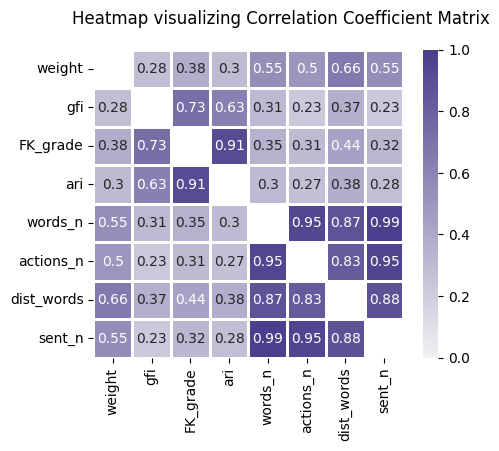

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Masking the diagonal cells   
masking = np.zeros_like(metrics_analisys, dtype = bool)  
np.fill_diagonal(masking, val = True)

# Generating a custom colormap
c_map = sns.light_palette("DarkSlateBlue", as_cmap=True)

# Print correlation heatmap
figure, axis = plt.subplots(figsize = (5, 4))
sns.heatmap(metrics_analisys, mask = masking, cmap = c_map, vmin = 0, vmax = 1, linewidths = 1, annot=True)  
figure.suptitle('Heatmap visualizing Correlation Coefficient Matrix', fontsize = 12)  
axis.tick_params(axis = 'both', which = 'major', labelsize = 10)  

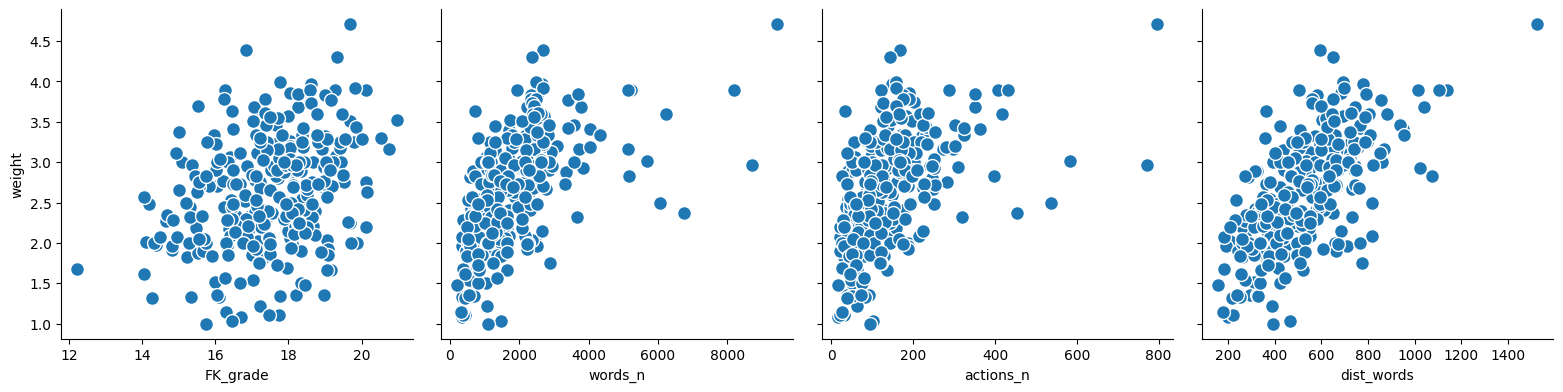

In [ ]:
g = sns.PairGrid(df, y_vars=["weight"], x_vars=['FK_grade', 'words_n', 'actions_n', 'dist_words'], height=4)
g.map(plt.scatter, s=100, edgecolor="white")

The dataframe and the plots printed above are useful to understand the correlation between the weight and the metrics computed by analisying the texts.
As can be seen, the syntactic complexity of the rules seems not to be directly correlated to the complexity of the game. Instead, the mother metrics seems to have a correlation, with the *number of distinct words* being the metric with the most direct correlation.

## **Enrich *actions* approach**

Removing from the *action words set* all the word tht are not a verb.

In [ ]:
from nltk.corpus import wordnet as wn
nltk.download('wordnet')

pos_all = dict()
wordsToRemove = list()

for w in w2v_actions:
    pos_l = set()
    word = w[:-1] if w[-1] == 's' else w
    for tmp in wn.synsets(word):
        if tmp.name().split('.')[0] == word:
            pos_l.add(tmp.pos())
    if 'v' not in pos_l:
        wordsToRemove.append(w)

for w in wordsToRemove:
    w2v_actions.remove(w)

w2v_actions

[nltk_data] Downloading package wordnet to /root/nltk_data...


{'acquire',
 'act',
 'activate',
 'add',
 'advance',
 'afford',
 'agree',
 'appear',
 'attach',
 'attack',
 'attacks',
 'box',
 'buy',
 'change',
 'collect',
 'come',
 'complete',
 'control',
 'count',
 'counterattack',
 'counts',
 'create',
 'decide',
 'decks',
 'defend',
 'deploy',
 'discard',
 'discards',
 'dodge',
 'draw',
 'draws',
 'earn',
 'engage',
 'enter',
 'equip',
 'evade',
 'exchange',
 'execute',
 'exhaust',
 'explore',
 'fill',
 'fit',
 'flip',
 'form',
 'gain',
 'generate',
 'get',
 'give',
 'gives',
 'go',
 'hand',
 'hire',
 'keep',
 'lose',
 'mine',
 'move',
 'moves',
 'perform',
 'pirate',
 'place',
 'places',
 'play',
 'proceed',
 'produce',
 'put',
 'read',
 'receive',
 'recover',
 'remove',
 'replace',
 'replenish',
 'reshuffle',
 'resolve',
 'restore',
 'result',
 'retaliate',
 'return',
 'returns',
 'reveal',
 'reveals',
 'roll',
 'rolls',
 'score',
 'sell',
 'send',
 'shoot',
 'show',
 'shuffle',
 'shuffles',
 'slot',
 'spend',
 'steal',
 'take',
 'teleport',
 

Divide text into paragraphs

In [ ]:
import re

paragraphs = list()
pattern = '\.\n|\. \n'

for r in df['raw_rules']:
    paragraphs.append([x.replace('\n', ' ') for x in re.split(pattern, r)])

df['paragraphs'] = paragraphs

Count the number of rules. A paragraph is considered a rule if an *action word* appear at least 3 times

In [ ]:
counters = list()
for p in df['paragraphs']:
    tmp = 0
    for paragraph in p:
        if sum(paragraph.count(x) for x in w2v_actions) > 2:
            tmp += 1
    counters.append(tmp)
    
df['rules_count'] = counters
df

,id,name,year,publisher,weight,rules,raw_rules,words_n,words_freq,dist_words,sent_n,gfi,FK_grade,ari,actions_n,paragraphs,rules_count
0,367525,3000 SCOUNDRELS,2022,UNEXPECTED GAMES,2.1667,"setup before your first game, place all clear ...","SETUP\nBefore your first game, place all clear...",1659,"{'setup': 4, 'first': 8, 'game': 19, 'place': ...",530,183,8.869587,16.360884,19.539279,217,"[SETUP Before your first game, place all clear...",56
1,154173,7 RONIN,2013,GREY FOX GAMES,2.2105,setup choose or determine randomly who is the ...,SETUP\nChoose or determine randomly who is the...,802,"{'setup': 1, 'choose': 3, 'determine': 1, 'ran...",314,73,11.632123,18.665480,21.191106,66,[SETUP Choose or determine randomly who is the...,28
2,68448,7 WONDERS,2010,ASMODEE,2.3211,"setup depending on the number of players, retu...","Setup\nDepending on the number of players, ret...",1150,"{'setup': 2, 'depending': 3, 'number': 7, 'pla...",441,112,10.192090,16.898638,20.740911,125,"[Setup Depending on the number of players, ret...",35
3,141517,A STUDY IN EMERALD,2013,TREEFROG GAMES,3.4538,setup shuffle the secret identity cards and de...,SETUP\nShuffle the Secret Identity cards and d...,1309,"{'setup': 1, 'shuffle': 7, 'secret': 11, 'iden...",423,135,9.854469,17.353511,20.774313,224,[SETUP Shuffle the Secret Identity cards and d...,55
4,253499,A WAR OF WHISPERS,2020,STARLING GAMES,2.5488,setup each player chooses a matching player bo...,SETUP\nEach player chooses a matching player b...,898,"{'setup': 2, 'player': 24, 'chooses': 1, 'matc...",381,81,10.356158,18.378247,21.279201,131,[SETUP Each player chooses a matching player b...,37
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
304,146451,WRATH OF KINGS,2014,COOL MINI OR NOT,2.9000,basics distances (in inches) may be measured a...,BASICS\nDistances (in inches) may be measured ...,2288,"{'basics': 1, 'distances': 1, 'inches': 7, 'ma...",749,232,11.165895,19.128060,20.670510,275,[BASICS Distances (in inches) may be measured ...,85
305,8593,WRECKAGE,2003,FANTASY FLIGHT GAMES,1.7222,setup 1. starting with a randomly chosen first...,Setup\n1. Starting with a randomly chosen firs...,796,"{'setup': 1, '1.': 1, 'starting': 2, 'randomly...",371,68,12.224870,17.674792,20.156220,96,[Setup 1. Starting with a randomly chosen firs...,18
306,38868,ZANZIAR,2009,DRAGON DAWN PRODUCTIONS,3.5625,setup each player takes: 3 pairs of adventurin...,Setup\nEach player takes:\n3 pairs of Adventur...,2433,"{'setup': 1, 'player': 28, 'takes': 4, '3': 19...",789,232,10.731632,17.483434,19.846099,282,[Setup Each player takes: 3 pairs of Adventuri...,60
307,2471,ZOMBIES!!!,2001,"TWILIGHT CREATIONS, INC.",1.6142,setup place the town square tile in the centre...,SETUP\nPlace the Town Square tile in the centr...,433,"{'setup': 1, 'place': 6, 'town': 3, 'square': ...",256,29,11.003642,14.051117,15.742238,65,[SETUP Place the Town Square tile in the centr...,10


In [ ]:
df['rules_count_freq'] = df['rules_count'] / df['words_n']
df

,id,name,year,publisher,weight,rules,raw_rules,words_n,words_freq,dist_words,sent_n,gfi,FK_grade,ari,actions_n,paragraphs,rules_count,rules_count_freq
0,367525,3000 SCOUNDRELS,2022,UNEXPECTED GAMES,2.1667,"setup before your first game, place all clear ...","SETUP\nBefore your first game, place all clear...",1659,"{'setup': 4, 'first': 8, 'game': 19, 'place': ...",530,183,8.869587,16.360884,19.539279,217,"[SETUP Before your first game, place all clear...",56,0.033755
1,154173,7 RONIN,2013,GREY FOX GAMES,2.2105,setup choose or determine randomly who is the ...,SETUP\nChoose or determine randomly who is the...,802,"{'setup': 1, 'choose': 3, 'determine': 1, 'ran...",314,73,11.632123,18.665480,21.191106,66,[SETUP Choose or determine randomly who is the...,28,0.034913
2,68448,7 WONDERS,2010,ASMODEE,2.3211,"setup depending on the number of players, retu...","Setup\nDepending on the number of players, ret...",1150,"{'setup': 2, 'depending': 3, 'number': 7, 'pla...",441,112,10.192090,16.898638,20.740911,125,"[Setup Depending on the number of players, ret...",35,0.030435
3,141517,A STUDY IN EMERALD,2013,TREEFROG GAMES,3.4538,setup shuffle the secret identity cards and de...,SETUP\nShuffle the Secret Identity cards and d...,1309,"{'setup': 1, 'shuffle': 7, 'secret': 11, 'iden...",423,135,9.854469,17.353511,20.774313,224,[SETUP Shuffle the Secret Identity cards and d...,55,0.042017
4,253499,A WAR OF WHISPERS,2020,STARLING GAMES,2.5488,setup each player chooses a matching player bo...,SETUP\nEach player chooses a matching player b...,898,"{'setup': 2, 'player': 24, 'chooses': 1, 'matc...",381,81,10.356158,18.378247,21.279201,131,[SETUP Each player chooses a matching player b...,37,0.041203
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
304,146451,WRATH OF KINGS,2014,COOL MINI OR NOT,2.9000,basics distances (in inches) may be measured a...,BASICS\nDistances (in inches) may be measured ...,2288,"{'basics': 1, 'distances': 1, 'inches': 7, 'ma...",749,232,11.165895,19.128060,20.670510,275,[BASICS Distances (in inches) may be measured ...,85,0.037150
305,8593,WRECKAGE,2003,FANTASY FLIGHT GAMES,1.7222,setup 1. starting with a randomly chosen first...,Setup\n1. Starting with a randomly chosen firs...,796,"{'setup': 1, '1.': 1, 'starting': 2, 'randomly...",371,68,12.224870,17.674792,20.156220,96,[Setup 1. Starting with a randomly chosen firs...,18,0.022613
306,38868,ZANZIAR,2009,DRAGON DAWN PRODUCTIONS,3.5625,setup each player takes: 3 pairs of adventurin...,Setup\nEach player takes:\n3 pairs of Adventur...,2433,"{'setup': 1, 'player': 28, 'takes': 4, '3': 19...",789,232,10.731632,17.483434,19.846099,282,[Setup Each player takes: 3 pairs of Adventuri...,60,0.024661
307,2471,ZOMBIES!!!,2001,"TWILIGHT CREATIONS, INC.",1.6142,setup place the town square tile in the centre...,SETUP\nPlace the Town Square tile in the centr...,433,"{'setup': 1, 'place': 6, 'town': 3, 'square': ...",256,29,11.003642,14.051117,15.742238,65,[SETUP Place the Town Square tile in the centr...,10,0.023095


#### **Weight x Rules Count**

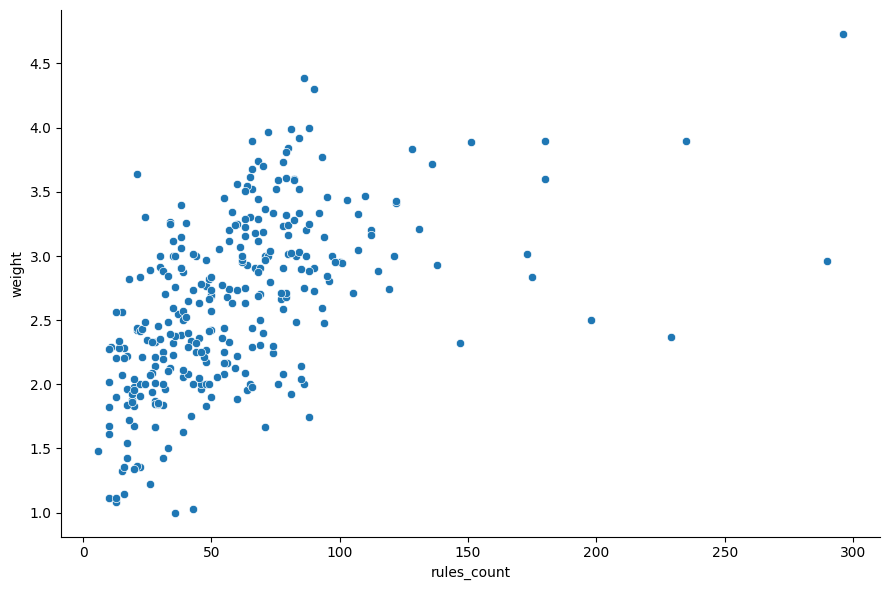

In [ ]:
import seaborn as sns

sns.relplot(data=df, x="rules_count", y="weight", height=6, aspect=1.5)

### **Custom weight**

Compute a weight (from 1 to 5) based on the number of rules counted in previous steps

In [ ]:
'''
RULES COUNT:
0-40 -> 1
40-80 -> 2
80-120 -> 3
120-160 -> 4
> 160 -> 5
'''

def custom_weight(rules_count):
    w = 1 + rules_count / 40
    if w <= 5:
        return w
    else:
        return 5

df['custom_weight'] = [custom_weight(x) for x in df['rules_count']]

#df['diff'] = [0 if x['weight'] > x['custom_weight'] else 1 for x in df]
#df

#### **Weight x Custom Weight**

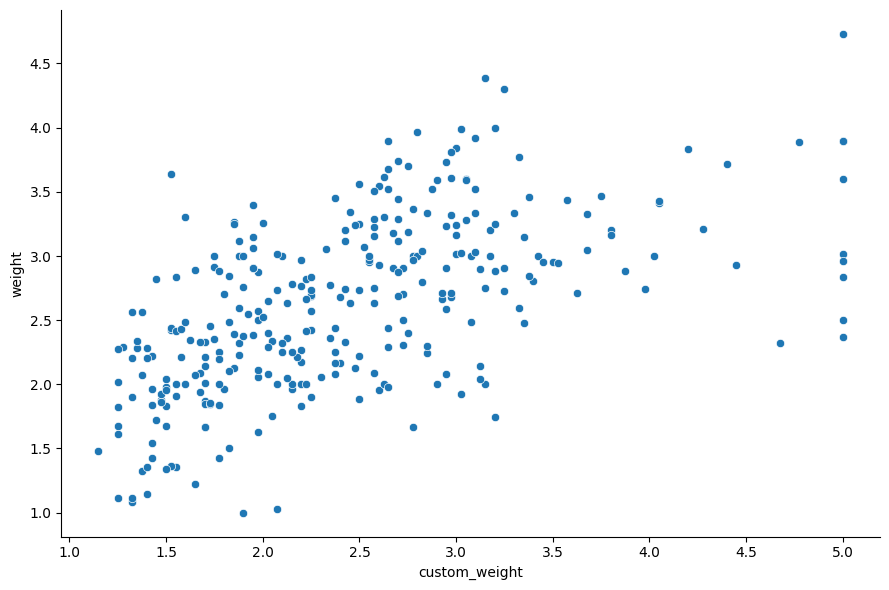

In [ ]:
sns.relplot(data=df, x="custom_weight", y="weight", height=6, aspect=1.5)

## **Labelling weights**

In [ ]:
labels_array = list()
cust_labels_array = list()
LABELS = ['EASY', 'MEDIUM', 'HARD']

for i in range(len(df['weight'])):
    labels_array.append( LABELS[ int((df.iloc[i]['weight'] - 1) // 1.34) ] )
    cust_labels_array.append( LABELS[ int((df.iloc[i]['custom_weight'] - 1) // 1.34) ] )

df['label'] = labels_array
df['custom_label'] = cust_labels_array

### **Pairs matrix**

Build a matrix with occurrences for each pair of label and custom label

In [ ]:
import numpy as np

'''
labels_pair_matrix:

        EASY MEDIUM HARD
EASY      0     0    0
MEDIUM    0     0    0
HARD      0     0    0

'''

labels_pair_matrix = np.zeros((3, 3)).astype(int)
label_dic = {'EASY': 0, 'MEDIUM': 1, 'HARD': 2}

for i in range(len(df['label'])):
    label = df.iloc[i]['label']
    custom_label = df.iloc[i]['custom_label']
    labels_pair_matrix[label_dic.get(label)][label_dic.get(custom_label)] += 1

df_labels = pd.DataFrame(labels_pair_matrix, index=LABELS, columns=LABELS)
df_labels

,EASY,MEDIUM,HARD
EASY,91,24,1
MEDIUM,62,95,16
HARD,0,14,6


## **Results**

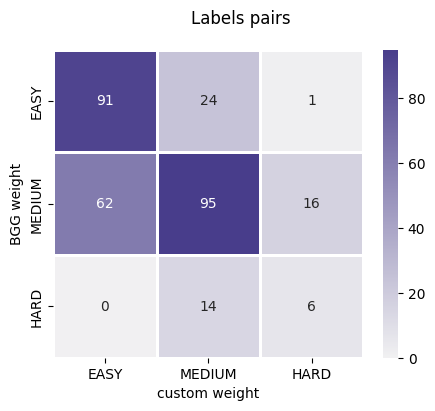

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Generating a custom colormap
c_map = sns.light_palette("DarkSlateBlue", as_cmap=True)

# Print correlation heatmap
figure, axis = plt.subplots(figsize = (5, 4))
s = sns.heatmap(df_labels, cmap = c_map, linewidths = 1, annot=True)  
s.set(xlabel='custom weight', ylabel='BGG weight')
figure.suptitle('Labels pairs', fontsize = 12)  
axis.tick_params(axis = 'both', which = 'major', labelsize = 10)  